In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import plotting_utils as pu
import overview_plot_utils as opu
import sa_city_utils as sacu

from utils import roar_data_path as project_data_path
from utils import gev_metric_ids, trend_metric_ids
from utils import city_list

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
# Set fonts
from matplotlib import font_manager
font_dirs = ["/storage/home/dcl5300/fonts"]

font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.5

## Useful plotting functions

In [3]:
def plot_city_metrics(city, metric_ids, plot_col, hist_slice, proj_slice, fit_method, stationary, limits=None, store=True, legend=0, read_samples=True, title=None):
    # Make axes
    fig, axs = plt.subplots(2, len(metric_ids), height_ratios=[4, 1], figsize=(4*len(metric_ids),11))
    fig.suptitle(f"{pu.city_names[city]} {title}", fontweight='bold', fontsize=14)

    # Loop through examples
    for idx, metric_id in enumerate(metric_ids):
        axs_subset = axs[:,idx]

        pu.plot_city_results(
            city = city,
            metric_id = metric_id,
            plot_col = plot_col,
            hist_slice = hist_slice,
            proj_slice = proj_slice,
            fit_method = fit_method,
            stationary = stationary,
            axs = axs_subset,
            read_samples = read_samples,
            limits = limits[idx] if type(limits) == list else None,
            yticklabels = True if idx == 0 else False,
            legend = True if idx == legend else False,
        )

    plt.tight_layout()
    
    if store:
        plt.savefig(f'../figs/{city}_{plot_col}_{fit_method}_{stationary}_{hist_slice}_{proj_slice}.pdf')
    else:
        plt.show()

# Plots

In [4]:
# Read timeseries
city = "nashville"
metric_id = "min_tasmin"
var_id = metric_id.split('_')[1]
unit = '[C]'

# Read raw
df = pd.read_csv(f'{project_data_path}/metrics/cities/{city}_{metric_id}.csv')

# Drop TaiESM1
df = df[df['gcm'] != 'TaiESM1']

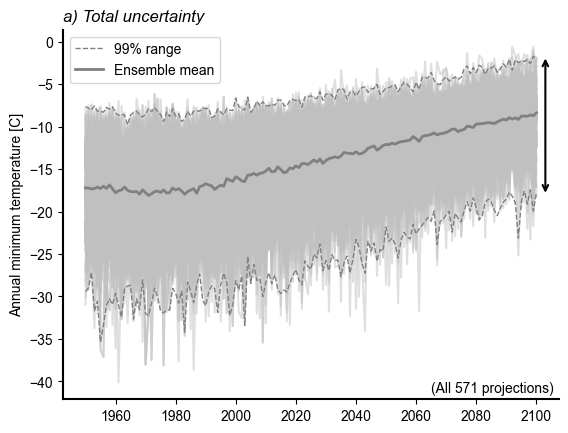

In [5]:
fig, ax = plt.subplots()
opu.plot_total_uncertainty(df, metric_id, unit, ax)
plt.show()

In [6]:
df_nonstat = pd.read_csv('/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/extreme_value/cities/original_grid/freq/nashville_min_tasmin_1950-2100_mle_nonstat_nboot100_samples.csv')
df_stat = pd.read_csv('/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/extreme_value/cities/original_grid/freq/nashville_min_tasmin_1950-2014_2050-2100_lmom_stat_nbootproj1000_nboothist1_samples.csv')

In [35]:
df_stat['100yr_return_level_proj'].quantile(0.995) - df_stat['100yr_return_level_proj'].quantile(0.005)

24.660729706454816

In [82]:
df_stat.query('n_boot == "main"')['100yr_return_level_proj'].quantile(0.995) - df_stat.query('n_boot == "main"')['100yr_return_level_proj'].quantile(0.005)

15.767957553023338

In [17]:
df_stat.query('n_boot == "main"')['100yr_return_level_diff'].max() - df_stat.query('n_boot == "main"')['100yr_return_level_diff'].min()

27.329718098069225

In [36]:
ds = xr.open_dataset('/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/results/min_tasmin_2050-2100_1950-2014_100yr_return_level_proj_lmom_stat_LOCA2grid_nearest.nc')
ds.sel(lat=city_list['nashville'][0], lon=360+city_list['nashville'][1], method='nearest')['uc_99w'].values

array(33.76057746)

In [12]:
df_stat.query('n_boot == "main" and ensemble == "LOCA2" and gcm == ').sort_values('100yr_return_level_proj')

,ensemble,gcm,member,ssp,n_boot,loc_hist,scale_hist,shape_hist,loc_proj,scale_proj,...,50yr_return_level_proj,100yr_return_level_proj,10yr_return_level_diff,25yr_return_level_diff,50yr_return_level_diff,100yr_return_level_diff,10yr_return_level_chfc,25yr_return_level_chfc,50yr_return_level_chfc,100yr_return_level_chfc
315315,LOCA2,INM-CM4-8,r1i1p1f1,ssp585,main,14.047751,3.631284,-0.254243,10.938802,2.155248,...,-26.437384,-31.540658,7.321198,9.741943,11.844320,14.222761,0.708026,0.695320,0.690601,0.689211
230230,LOCA2,BCC-CSM2-MR,r1i1p1f1,ssp245,main,19.262616,3.963255,0.156628,12.926341,4.497876,...,-28.909367,-31.462434,4.266024,2.985875,1.923956,0.793501,0.840696,0.897862,0.937601,0.975400
276276,LOCA2,EC-Earth3,r4i1p1f1,ssp245,main,15.824235,5.212520,0.241519,9.028317,2.526550,...,-25.095968,-29.848333,8.371539,6.409545,3.900026,0.452795,0.663435,0.766404,0.865498,0.985057
164164,GARD-LENS,EC-Earth3,r115i1p1f1,ssp370,main,16.097319,4.183302,0.206682,8.135412,2.147745,...,-23.949092,-29.260750,8.611855,6.284082,3.352531,-0.744885,0.635483,0.757256,0.877204,1.026122
316316,LOCA2,INM-CM5-0,r1i1p1f1,ssp245,main,14.111780,3.855702,-0.110771,11.466769,1.960738,...,-24.799627,-28.983887,6.483951,7.619257,8.131941,8.259929,0.729449,0.736465,0.753065,0.778220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30030,GARD-LENS,CESM2-LENS,1231_11,ssp370,main,14.159587,3.882028,0.177760,8.904131,1.823614,...,-13.626133,-14.112150,9.241463,10.578108,11.457795,12.245701,0.567341,0.552349,0.543222,0.535406
439439,STAR-ESDM,GFDL-CM4,r1i1p1f1,ssp585,main,13.515707,3.272823,0.014465,8.697447,2.498855,...,-13.657050,-13.981237,8.345227,10.519707,12.275314,14.099975,0.598056,0.556981,0.526641,0.497886
38038,GARD-LENS,CESM2-LENS,1231_19,ssp370,main,13.709423,2.948947,0.072369,8.162407,1.816809,...,-13.254790,-13.845198,8.309469,9.549647,10.479331,11.402802,0.581037,0.568468,0.558470,0.548368
249249,LOCA2,CNRM-ESM2-1,r1i1p1f2,ssp585,main,13.490278,3.977966,0.145094,5.828896,2.076796,...,-12.724565,-13.734663,11.045309,12.025356,12.617623,13.107069,0.477209,0.491953,0.502110,0.511691


In [15]:
df_stat.groupby(['ensemble', 'gcm', 'member', 'ssp'])['100yr_return_level_proj'].quantile(0.025).sort_values()

ensemble   gcm         member      ssp   
GARD-LENS  EC-Earth3   r115i1p1f1  ssp370   -49.384612
LOCA2      INM-CM4-8   r1i1p1f1    ssp585   -49.139041
           EC-Earth3   r4i1p1f1    ssp245   -48.766637
STAR-ESDM  KACE-1-0-G  r1i1p1f1    ssp585   -45.820885
LOCA2      INM-CM4-8   r1i1p1f1    ssp370   -45.033415
                                               ...    
           NorESM2-LM  r1i1p1f1    ssp585   -16.358538
GARD-LENS  CESM2-LENS  1231_11     ssp370   -15.917772
                       1231_19     ssp370   -15.811132
STAR-ESDM  INM-CM5-0   r1i1p1f1    ssp585   -15.669928
           GFDL-CM4    r1i1p1f1    ssp585   -15.367182
Name: 100yr_return_level_proj, Length: 466, dtype: float64

In [13]:
df_stat.groupby(['ensemble', 'gcm', 'member', 'ssp'])['100yr_return_level_proj'].quantile(0.975).sort_values()

ensemble   gcm            member      ssp   
LOCA2      BCC-CSM2-MR    r1i1p1f1    ssp245   -25.117881
           INM-CM4-8      r1i1p1f1    ssp585   -20.863908
GARD-LENS  EC-Earth3      r131i1p1f1  ssp370   -20.725654
LOCA2      BCC-CSM2-MR    r1i1p1f1    ssp370   -20.338169
GARD-LENS  EC-Earth3      r145i1p1f1  ssp370   -20.023294
                                                  ...    
LOCA2      MIROC6         r4i1p1f1    ssp585   -11.761095
           NorESM2-LM     r1i1p1f1    ssp585   -11.542586
STAR-ESDM  EC-Earth3-Veg  r1i1p1f1    ssp585   -11.533535
LOCA2      CNRM-ESM2-1    r1i1p1f2    ssp585   -11.080928
                                      ssp245   -11.077305
Name: 100yr_return_level_proj, Length: 466, dtype: float64

In [37]:
df_stat.groupby(['ensemble', 'gcm', 'member', 'ssp'])['100yr_return_level_proj'].quantile(0.975).quantile(0.995) - df_stat.groupby(['ensemble', 'gcm', 'member', 'ssp'])['100yr_return_level_proj'].quantile(0.025).quantile(0.005)

36.272790960590854

In [38]:
df_stat.groupby(['ensemble', 'gcm', 'member', 'ssp'])['100yr_return_level_proj'].quantile(0.975).quantile(0.995)

-11.536476471554597

In [39]:
df_stat['100yr_return_level_proj'].quantile(0.995)

-12.795567165054623

<Axes: ylabel='Frequency'>

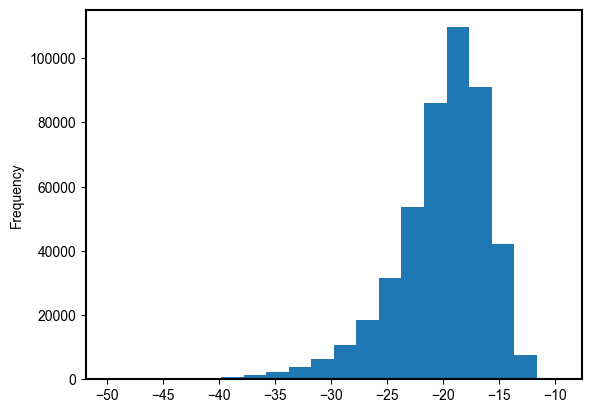

In [53]:
df_stat[df_stat["100yr_return_level_proj"] > -50]["100yr_return_level_proj"].plot.hist(bins=20)

<Axes: xlabel='time'>

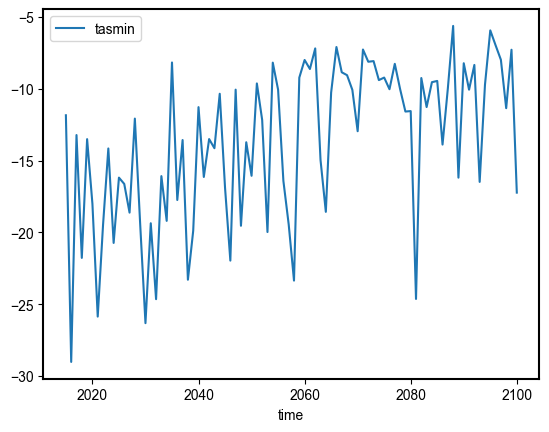

In [64]:
df.query('ensemble == "LOCA2" and gcm == "EC-Earth3" and member == "r4i1p1f1" and ssp == "ssp245"').plot(x='time', y='tasmin')

<Axes: ylabel='Frequency'>

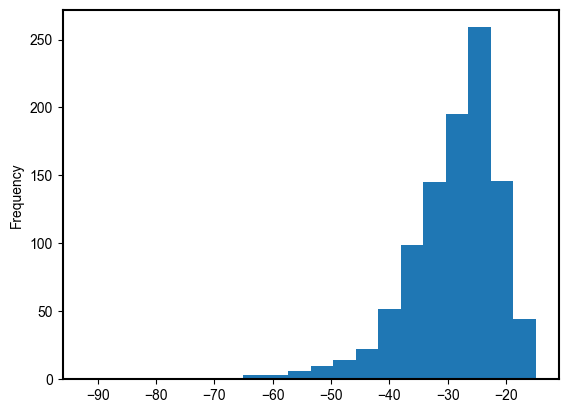

In [68]:
df_stat.query('ensemble == "GARD-LENS" and gcm == "EC-Earth3" and member == "r115i1p1f1"')['100yr_return_level_proj'].plot.hist(bins=20)

In [69]:
ds = xr.open_dataset('/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/extreme_value/original_grid/min_tasmin/GARD-LENS_ecearth3_r115i1p1f1_ssp370_2050-2100_1950-2014_stat_lmom_nbootproj100_nboothist1.nc')

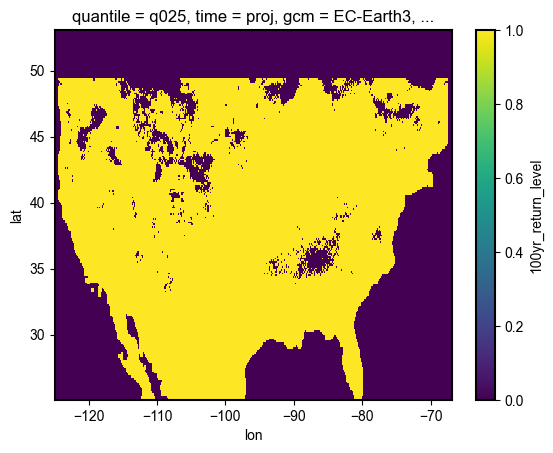

In [80]:
(ds.sel(quantile='q025')['100yr_return_level'].sel(time='proj') > -40).plot()

In [58]:
df_stat.groupby(['ensemble', 'gcm', 'member', 'ssp'])['100yr_return_level_proj'].quantile(0.025).sort_values()#.plot.hist(bins=20)

ensemble   gcm         member      ssp   
GARD-LENS  EC-Earth3   r115i1p1f1  ssp370   -49.384612
LOCA2      INM-CM4-8   r1i1p1f1    ssp585   -49.139041
           EC-Earth3   r4i1p1f1    ssp245   -48.766637
STAR-ESDM  KACE-1-0-G  r1i1p1f1    ssp585   -45.820885
LOCA2      INM-CM4-8   r1i1p1f1    ssp370   -45.033415
                                               ...    
           NorESM2-LM  r1i1p1f1    ssp585   -16.358538
GARD-LENS  CESM2-LENS  1231_11     ssp370   -15.917772
                       1231_19     ssp370   -15.811132
STAR-ESDM  INM-CM5-0   r1i1p1f1    ssp585   -15.669928
           GFDL-CM4    r1i1p1f1    ssp585   -15.367182
Name: 100yr_return_level_proj, Length: 466, dtype: float64

In [54]:
df_stat.groupby(['ensemble', 'gcm', 'member', 'ssp'])['100yr_return_level_proj'].quantile(0.025).quantile(0.005)

-47.809267432145454

In [42]:
df_stat['100yr_return_level_proj'].quantile(0.005)

-37.45629687150944

In [17]:
df_stat['100yr_return_level_diff'].quantile(0.995) - df_stat['100yr_return_level_diff'].quantile(0.005)

29.713171526507672

In [20]:
ds = xr.open_dataset('/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/results/min_tasmin_2050-2100_1950-2014_100yr_return_level_diff_lmom_stat_LOCA2grid_nearest.nc')
ds.sel(lat=city_list['nashville'][0], lon=360+city_list['nashville'][1], method='nearest')['uc_99w'].values

array(39.15188388)

In [12]:
df_stat['100yr_return_level_diff'].quantile(0.995)

22.361835078063034

In [34]:
df_stat.query('ensemble == "LOCA2" and gcm == "INM-CM4-8" and member == "r1i1p1f1" and ssp == "ssp585" and n_boot == "main"')

,ensemble,gcm,member,ssp,n_boot,loc_hist,scale_hist,shape_hist,loc_proj,scale_proj,...,50yr_return_level_proj,100yr_return_level_proj,10yr_return_level_diff,25yr_return_level_diff,50yr_return_level_diff,100yr_return_level_diff,10yr_return_level_chfc,25yr_return_level_chfc,50yr_return_level_chfc,100yr_return_level_chfc
315315,LOCA2,INM-CM4-8,r1i1p1f1,ssp585,main,14.047751,3.631284,-0.254243,10.938802,2.155248,...,-26.437384,-31.540658,7.321198,9.741943,11.84432,14.222761,0.708026,0.69532,0.690601,0.689211


In [35]:
df_nonstat.query('ensemble == "LOCA2" and gcm == "INM-CM4-8" and member == "r1i1p1f1" and ssp == "ssp585" and n_boot == "main"')

,ensemble,gcm,member,ssp,n_boot,loc_intcp,loc_trend,scale,shape,10yr_return_level_1950,...,100yr_return_level_2075,100yr_return_level_2100,10yr_return_level_diff_2075-1975,25yr_return_level_diff_2075-1975,50yr_return_level_diff_2075-1975,100yr_return_level_diff_2075-1975,10yr_return_level_chfc_2075-1975,25yr_return_level_chfc_2075-1975,50yr_return_level_chfc_2075-1975,100yr_return_level_chfc_2075-1975
31815,LOCA2,INM-CM4-8,r1i1p1f1,ssp585,main,14.172944,-0.025004,2.582632,-0.456964,-24.325754,...,-51.645713,-51.020603,2.500439,2.500439,2.500439,2.500439,0.894499,0.922519,0.939766,0.953821


In [43]:
df.query('ensemble == "LOCA2" and gcm == "INM-CM4-8" and member == "r1i1p1f1" and (ssp == "ssp585" or ssp == "historical")')

,gcm,member,ssp,ensemble,time,tasmin
13314,INM-CM4-8,r1i1p1f1,historical,LOCA2,1950,-17.340027
13315,INM-CM4-8,r1i1p1f1,historical,LOCA2,1951,-14.092468
13316,INM-CM4-8,r1i1p1f1,historical,LOCA2,1952,-12.744110
13317,INM-CM4-8,r1i1p1f1,historical,LOCA2,1953,-11.917084
13318,INM-CM4-8,r1i1p1f1,historical,LOCA2,1954,-21.693740
...,...,...,...,...,...,...
13632,INM-CM4-8,r1i1p1f1,ssp585,LOCA2,2096,-10.438477
13633,INM-CM4-8,r1i1p1f1,ssp585,LOCA2,2097,-11.746216
13634,INM-CM4-8,r1i1p1f1,ssp585,LOCA2,2098,-8.799286
13635,INM-CM4-8,r1i1p1f1,ssp585,LOCA2,2099,-10.436645


In [44]:
data = df.query('ensemble == "LOCA2" and gcm == "INM-CM4-8" and member == "r1i1p1f1" and (ssp == "ssp585" or ssp == "historical")')['tasmin'].to_numpy()

In [38]:
import gev_nonstat_utils as gevsu

In [45]:
gevsu._fit_gev_1d_nonstationary(data * -1, 151)

(14.172943819688731,
 -0.025004392460882693,
 2.5826318437982616,
 -0.4569640093288808)

In [10]:
df_nonstat = pd.read_csv('/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/extreme_value/cities/original_grid/freq/nashville_min_tasmin_1950-2100_mle_nonstat_nboot100_samples.csv')
df_stat = pd.read_csv('/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/extreme_value/cities/original_grid/freq/nashville_min_tasmin_1950-2014_2050-2100_lmom_stat_nbootproj1000_nboothist1_samples.csv')

In [14]:
plot_col = '100yr_return_level_2075'

df_nonstat.loc[df_nonstat["n_boot"] != "main", plot_col] = -df_nonstat.loc[df_nonstat["n_boot"] != "main", plot_col]

<Axes: ylabel='Frequency'>

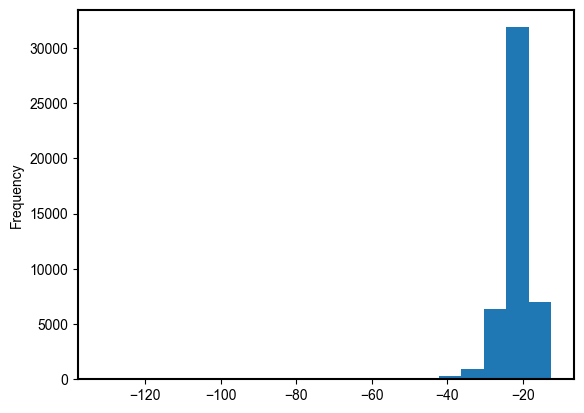

In [20]:
df_nonstat['100yr_return_level_2075'].plot.hist(bins=20)

In [28]:
df_nonstat.sort_values('100yr_return_level_2075')[['ensemble', 'gcm', 'member', 'ssp', 'n_boot', 'loc_intcp', 'loc_trend', 'scale', 'shape', '100yr_return_level_2075']].head(50)

,ensemble,gcm,member,ssp,n_boot,loc_intcp,loc_trend,scale,shape,100yr_return_level_2075
31868,LOCA2,INM-CM4-8,r1i1p1f1,ssp585,52,14.000972,-0.025350,2.732223,-0.774614,-131.747638
31844,LOCA2,INM-CM4-8,r1i1p1f1,ssp585,28,13.849997,-0.020274,2.895989,-0.618921,-87.295733
31897,LOCA2,INM-CM4-8,r1i1p1f1,ssp585,81,14.278672,-0.024474,2.844941,-0.611690,-84.119536
31817,LOCA2,INM-CM4-8,r1i1p1f1,ssp585,1,14.057839,-0.022279,2.505512,-0.615993,-76.382741
31870,LOCA2,INM-CM4-8,r1i1p1f1,ssp585,54,13.613318,-0.026050,2.274433,-0.647130,-75.823546
31908,LOCA2,INM-CM4-8,r1i1p1f1,ssp585,92,14.352358,-0.025391,2.614009,-0.598006,-75.247281
31856,LOCA2,INM-CM4-8,r1i1p1f1,ssp585,40,14.242928,-0.026767,2.846941,-0.571330,-74.922994
31816,LOCA2,INM-CM4-8,r1i1p1f1,ssp585,0,13.820196,-0.020624,2.658361,-0.585499,-73.815174
31764,LOCA2,INM-CM4-8,r1i1p1f1,ssp370,49,14.413760,-0.030096,2.915303,-0.541303,-70.229426
31794,LOCA2,INM-CM4-8,r1i1p1f1,ssp370,79,15.118319,-0.029405,3.141968,-0.512178,-70.025433


In [22]:
df_nonstat['100yr_return_level_2075'].quantile(0.005, interpolation='nearest')

-44.09795578243394

In [16]:
df_nonstat['100yr_return_level_2075'].quantile(0.995)

-15.759468789705455

## Figure 1

In [4]:
# Read timeseries
city = "boston"
metric_id = "max_tasmax"
var_id = metric_id.split('_')[1]
unit = '[C]'

# Read raw
df = pd.read_csv(f'{project_data_path}/metrics/cities/{city}_{metric_id}.csv')

# Drop TaiESM1
df = df[df['gcm'] != 'TaiESM1']

# Filter unrealistic values
df = df.query('tasmax < 50')

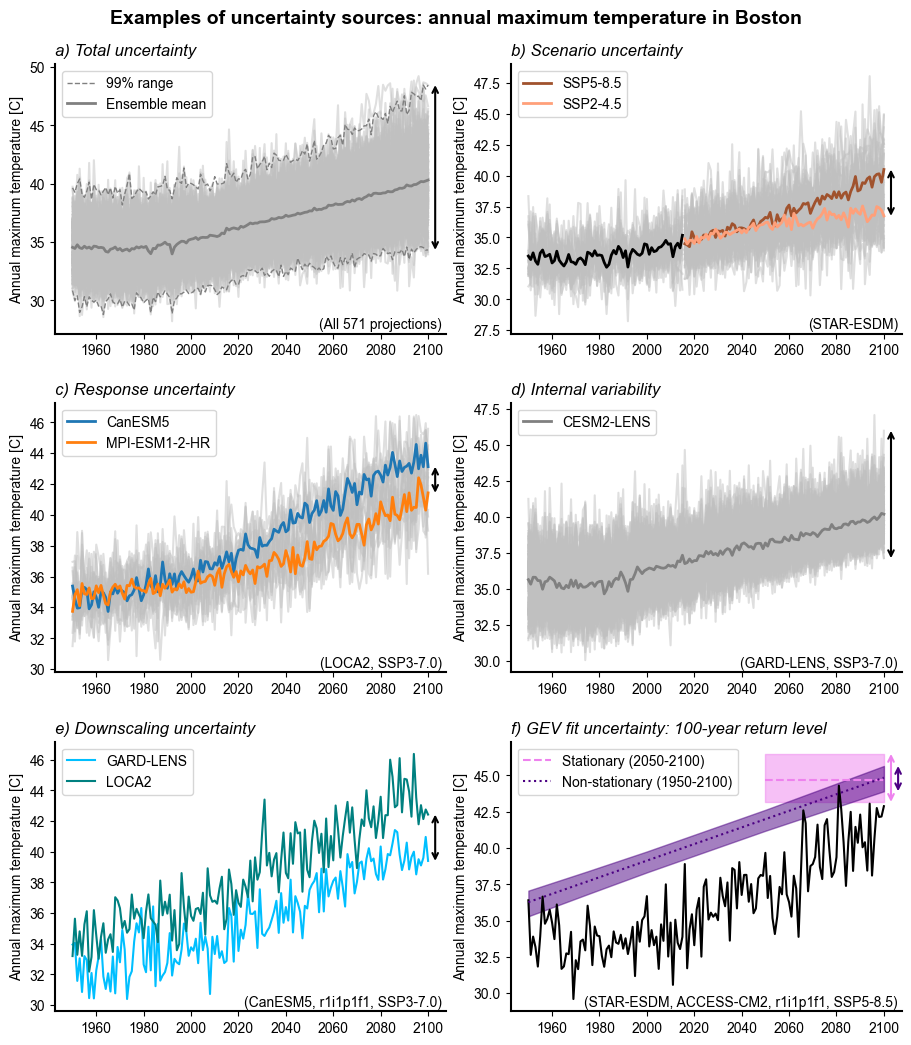

In [5]:
plt.rcParams["font.size"] = 10

# layout = """
# aabb
# ccdd
# .ee.
# """

## Timeseries plots
# fig = plt.figure(figsize=(9,10), layout='constrained')
# axs = fig.subplot_mosaic(
#     layout,
#     gridspec_kw={'hspace':0.075, 'wspace':0.01}
# )
fig, axs = plt.subplots(3, 2, figsize=(9,10), layout='constrained', gridspec_kw={'hspace':0.075, 'wspace':0.01})

opu.plot_total_uncertainty(df, metric_id, unit, axs[0,0])
opu.plot_scenario_uncertainty(df, metric_id, unit, axs[0,1])
opu.plot_response_uncertainty(df, metric_id, unit, axs[1,0])
opu.plot_internal_variability(df, metric_id, unit, axs[1,1])
opu.plot_downscaling_uncertainty(df, metric_id, unit, axs[2,0])
_ = opu.plot_gev_uncertainty(df, metric_id, unit, axs[2,1], city=city)

fig.suptitle('Examples of uncertainty sources: annual maximum temperature in Boston', fontweight='bold', fontsize=14, y=1.03)

plt.savefig('../figs/main/final/figure1.png', dpi=600, bbox_inches='tight')
# plt.show()

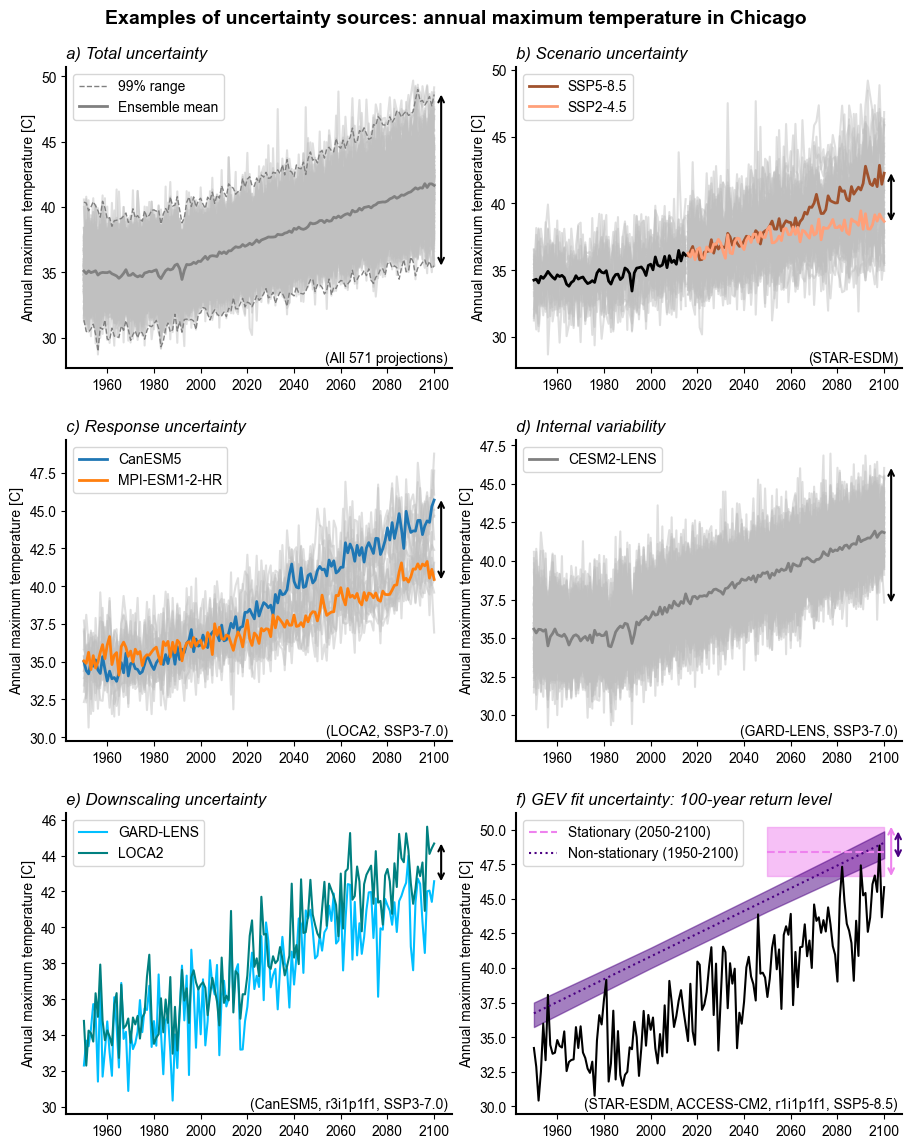

In [7]:
# Read timeseries
city = "chicago"
metric_id = "max_tasmax"
var_id = metric_id.split('_')[1]
unit = '[C]'

# Read raw
df = pd.read_csv(f'{project_data_path}/metrics/cities/{city}_{metric_id}.csv')

# Drop TaiESM1
df = df[df['gcm'] != 'TaiESM1']

# Filter unrealistic values
df = df.query('tasmax < 50')

## Timeseries plots
fig, axs = plt.subplots(3, 2, figsize=(9,11), layout='constrained', gridspec_kw={'hspace':0.075, 'wspace':0.01})

opu.plot_total_uncertainty(df, metric_id, unit, axs[0,0])
opu.plot_scenario_uncertainty(df, metric_id, unit, axs[0,1])
opu.plot_response_uncertainty(df, metric_id, unit, axs[1,0])
opu.plot_internal_variability(df, metric_id, unit, axs[1,1])
opu.plot_downscaling_uncertainty(df, metric_id, unit, axs[2,0], member = 'r3i1p1f1')
_ = opu.plot_gev_uncertainty(df, metric_id, unit, axs[2,1], city=city)

fig.suptitle('Examples of uncertainty sources: annual maximum temperature in Chicago', fontweight='bold', fontsize=14, y=1.03)

# plt.savefig('../figs/chicago_all.png', dpi=600, bbox_inches='tight')
plt.show()

# Other

### Robustness checks

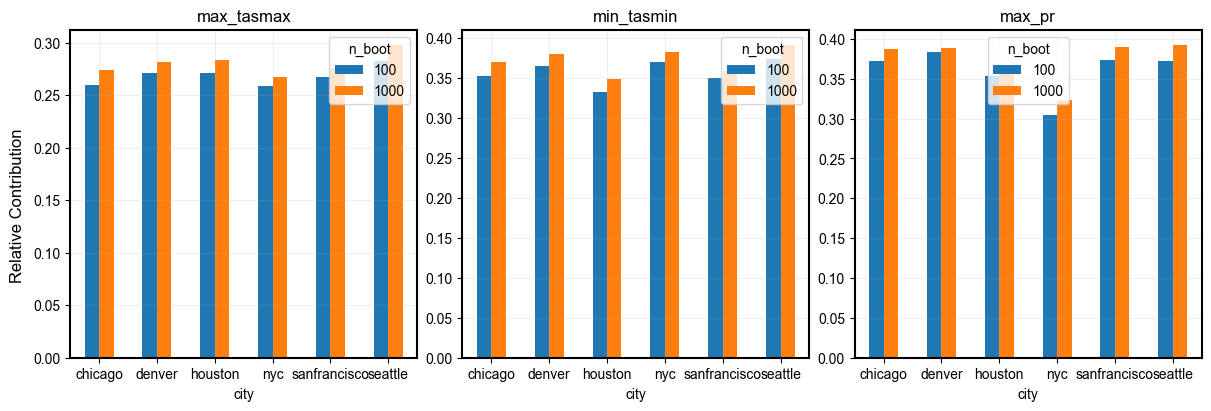

In [30]:
# Stationary check
n_boot_hist = 1
sample_str = "_samples"
stationary = 'stat'
fit_method = 'lmom'
proj_slice = '2050-2100'
hist_slice = '1950-2014'

df_check = pd.DataFrame()

for city in city_list:
    for metric_id in gev_metric_ids[:3]:
        # Read all
        df_1000 = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{hist_slice}_{proj_slice}_{fit_method}_{stationary}_nbootproj1000_nboothist{n_boot_hist}{sample_str}.csv")
        uc_1000 = sacu.calculate_df_uc(df_1000, '100yr_return_level_proj').set_index('uncertainty_type')
        df_100 = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{hist_slice}_{proj_slice}_{fit_method}_{stationary}_nbootproj100_nboothist{n_boot_hist}{sample_str}.csv")
        uc_100 = sacu.calculate_df_uc(df_100, '100yr_return_level_proj').set_index('uncertainty_type')

        # Append
        df_tmp = pd.DataFrame(data={'city': [city, city],
                                    'metric_id': [metric_id, metric_id],
                                    'n_boot': [100, 1000],
                                    'fit_uc_mean': [uc_100.loc['fit_uc']['mean']/uc_100.loc['uc_99w']['mean'],
                                                    uc_1000.loc['fit_uc']['mean']/uc_1000.loc['uc_99w']['mean']],
                                    'fit_uc_std': [uc_100.loc['fit_uc']['std']/uc_100.loc['uc_99w']['mean'],
                                                   uc_1000.loc['fit_uc']['std']/uc_1000.loc['uc_99w']['mean']]},
                              index=[0,1])
        df_check = pd.concat([df_check, df_tmp], ignore_index=True)

# Plot
fig, axs = plt.subplots(1,3, figsize=(12,4), layout='constrained')

for idx, metric_id in enumerate(gev_metric_ids[:3]):
    ax = axs[idx]
    dfp = df_check[df_check['metric_id'] == metric_id].pivot(index='city', columns='n_boot', values='fit_uc_mean')
    # yerr = df_check[df_check['metric_id'] == metric_id].pivot(index='city', columns='n_boot', values='fit_uc_std')
    dfp.plot(kind='bar', rot=0, capsize=3, ax=ax)
    ax.grid(alpha=0.2)
    ax.set_title(metric_id)

fig.supylabel('Relative Contribution')

plt.show()

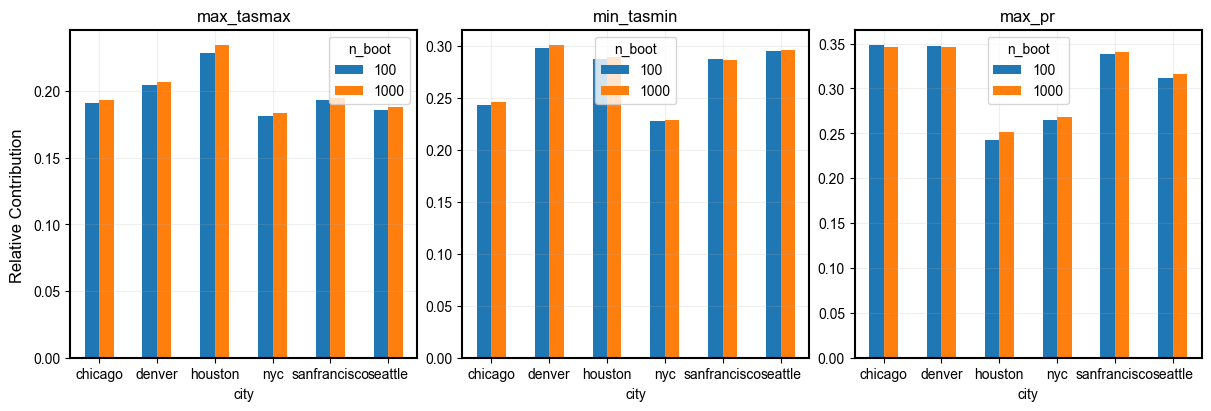

In [34]:
# Non-stationary check
n_boot = 1
sample_str = "_samples"
stationary = 'nonstat'
fit_method = 'mle'
proj_slice = '1950-2100'

df_check = pd.DataFrame()

for city in city_list:
    for metric_id in gev_metric_ids[:3]:
        # Read all
        df_1000 = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{proj_slice}_{fit_method}_{stationary}_nboot500{sample_str}.csv")
        uc_1000 = sacu.calculate_df_uc(df_1000, '100yr_return_level_2075').set_index('uncertainty_type')
        df_100 = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{proj_slice}_{fit_method}_{stationary}_nboot250{sample_str}.csv")
        uc_100 = sacu.calculate_df_uc(df_100, '100yr_return_level_2075').set_index('uncertainty_type')

        # Append
        df_tmp = pd.DataFrame(data={'city': [city, city],
                                    'metric_id': [metric_id, metric_id],
                                    'n_boot': [100, 1000],
                                    'fit_uc_mean': [uc_100.loc['fit_uc']['mean']/uc_100.loc['uc_99w']['mean'],
                                                    uc_1000.loc['fit_uc']['mean']/uc_1000.loc['uc_99w']['mean']],
                                    'fit_uc_std': [uc_100.loc['fit_uc']['std']/uc_100.loc['uc_99w']['mean'],
                                                   uc_1000.loc['fit_uc']['std']/uc_1000.loc['uc_99w']['mean']]},
                              index=[0,1])
        df_check = pd.concat([df_check, df_tmp], ignore_index=True)

# Plot
fig, axs = plt.subplots(1,3, figsize=(12,4), layout='constrained')

for idx, metric_id in enumerate(gev_metric_ids[:3]):
    ax = axs[idx]
    dfp = df_check[df_check['metric_id'] == metric_id].pivot(index='city', columns='n_boot', values='fit_uc_mean')
    # yerr = df_check[df_check['metric_id'] == metric_id].pivot(index='city', columns='n_boot', values='fit_uc_std')
    dfp.plot(kind='bar', rot=0, capsize=3, ax=ax)
    ax.grid(alpha=0.2)
    ax.set_title(metric_id)

fig.supylabel('Relative Contribution')

plt.show()

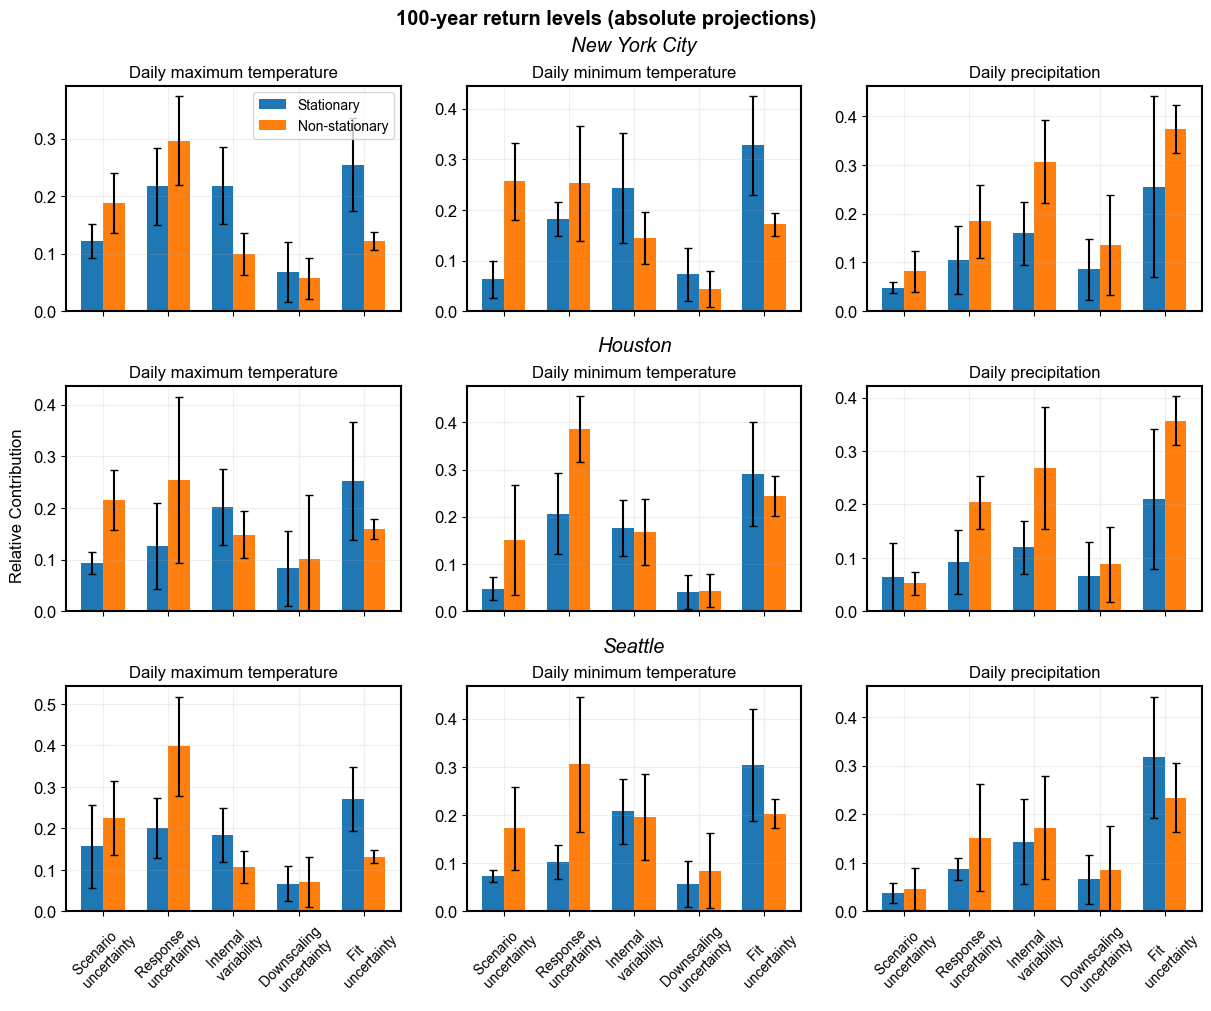

In [80]:
# Robustness checks
stat_n_boot = 1000
nonstat_n_boot = 250
sample_str = ""
stat_fit_method = 'lmom'
nonstat_fit_method = 'mle'
proj_slice = '2050-2100'
hist_slice = '1950-2014'
nonstat_slice = '1950-2100'
nonstat_diff = '2075-1975'

stat_cols = ['100yr_return_level_proj', '100yr_return_level_diff']
nonstat_cols = [f'100yr_return_level_{nonstat_diff.split('-')[0]}', f'100yr_return_level_diff_{nonstat_diff}']

# Combined
cities = ['nyc', 'houston', 'seattle']
gev_metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

metric_titles = {'tasmax': 'Daily maximum temperature', 
                 'tasmin': 'Daily minimum temperature', 
                 'pr': 'Daily precipitation'}

# Make figure
fig = plt.figure(figsize=(12, 10), layout='compressed')
gs = fig.add_gridspec(3, 3, hspace=0.05)

# Loop through cities
for idc, city in enumerate(cities):
    # Create city title
    ax_title = fig.add_subplot(gs[idc, :], frameon=False)
    ax_title.set_title(pu.city_names[city], fontstyle='italic', y=1.15, pad=0)
    ax_title.set_xticks([])
    ax_title.set_yticks([])

    # Loop through metrics
    for idm, gev_metric_id in enumerate(gev_metric_ids):
        # Make axis
        ax = plt.subplot(gs[idc, idm])
        # Get variable
        var_id = gev_metric_id.split('_')[1]
        
        # Read both datasets
        df_stat = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{gev_metric_id}_{hist_slice}_{proj_slice}_{stat_fit_method}_stat_nboot{stat_n_boot}{sample_str}.csv")
        df_stat_uc_proj = sacu.calculate_df_uc(df_stat, '100yr_return_level_proj').set_index('uncertainty_type')
        df_stat_uc_diff = sacu.calculate_df_uc(df_stat, '100yr_return_level_diff').set_index('uncertainty_type')
        
        df_nonstat = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{gev_metric_id}_{nonstat_slice}_{nonstat_fit_method}_nonstat_nboot{nonstat_n_boot}{sample_str}.csv")
        df_nonstat_uc_proj = sacu.calculate_df_uc(df_nonstat, f'100yr_return_level_{nonstat_diff.split('-')[0]}').set_index('uncertainty_type')
        df_nonstat_uc_diff = sacu.calculate_df_uc(df_nonstat, f'100yr_return_level_diff_{nonstat_diff}').set_index('uncertainty_type')
        
        # # Plot
        # pu.plot_uc_bars(dfs = [df_stat_uc_proj, df_stat_uc_diff, df_nonstat_uc_proj, df_nonstat_uc_diff],
        #                labels = ['Stationary (projection)', 'Stationary (change)', 'Non-stationary (projection)', 'Non-stationary (change)'],
        #                ax = ax, 
        #                legend=(idc==0 and idm==0))

        # Plot
        pu.plot_uc_bars(dfs = [df_stat_uc_diff, df_nonstat_uc_diff],
                       labels = ['Stationary', 'Non-stationary'],
                       ax = ax, 
                       legend=(idc==0 and idm==0))
        
        # Add metric title to each subplot
        ax.set_title(metric_titles[var_id], fontsize=12)
        
        # Only show x-labels on bottom row
        if idc < 2:
            ax.set_xticklabels([])

# Add global labels
fig.supylabel('Relative Contribution', fontsize=12)
fig.suptitle('100-year return levels (absolute projections)', fontweight='bold')

# plt.tight_layout()
plt.savefig('../figs/main/city_comparison_diff.pdf', bbox_inches='tight')
# plt.show()

### Other

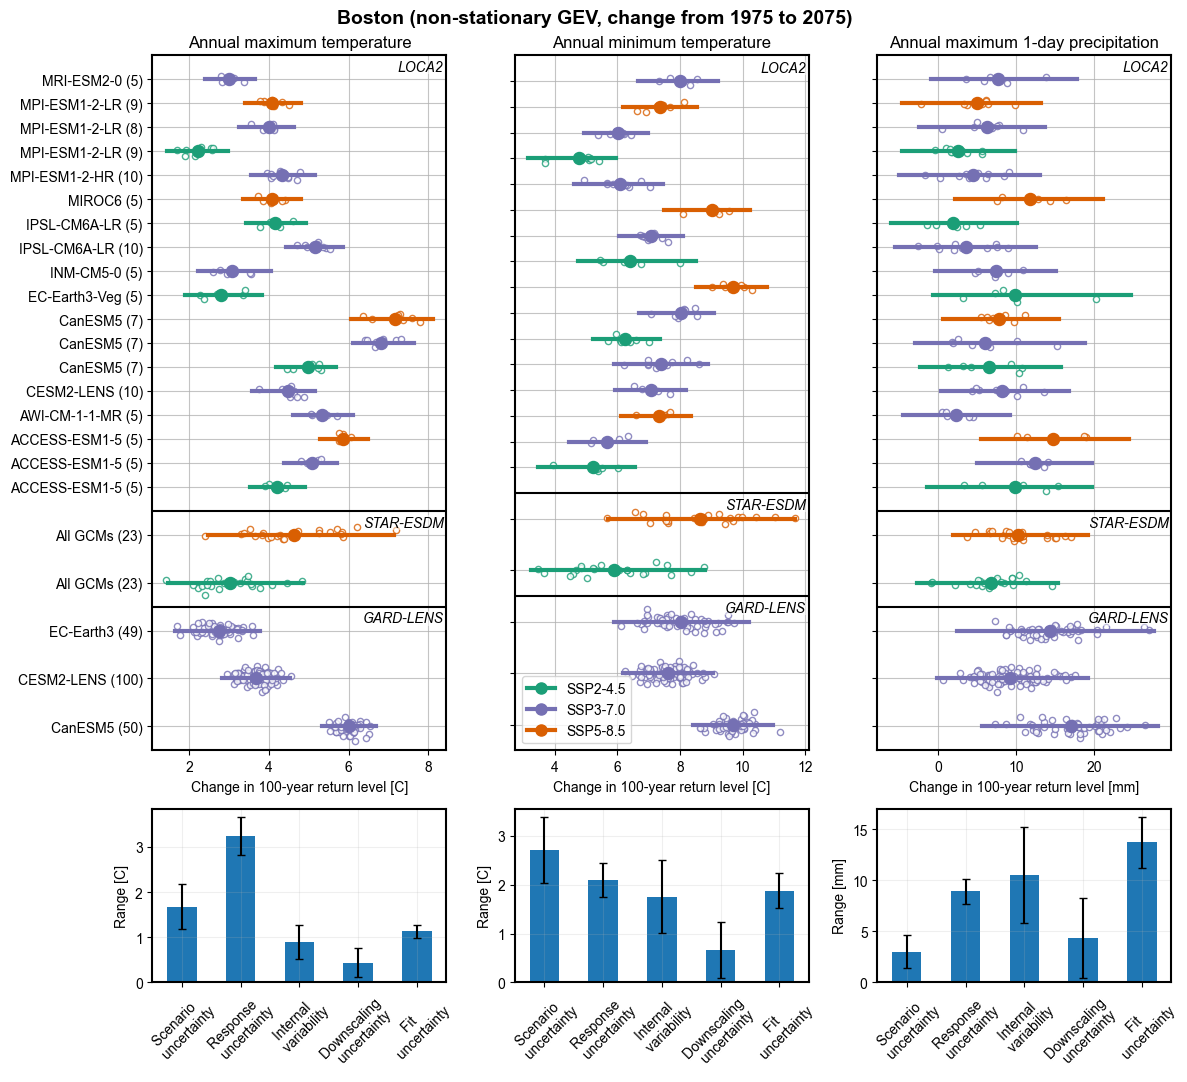

In [4]:
city = 'boston'
plot_col = '100yr_return_level_diff_2075-1975'
hist_slice = None
proj_slice = '1950-2100'
fit_method = 'mle'
stationary = False

metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

plot_city_metrics(city, metric_ids, plot_col, hist_slice, proj_slice, fit_method, stationary, title = '(non-stationary GEV, change from 1975 to 2075)', legend=1)

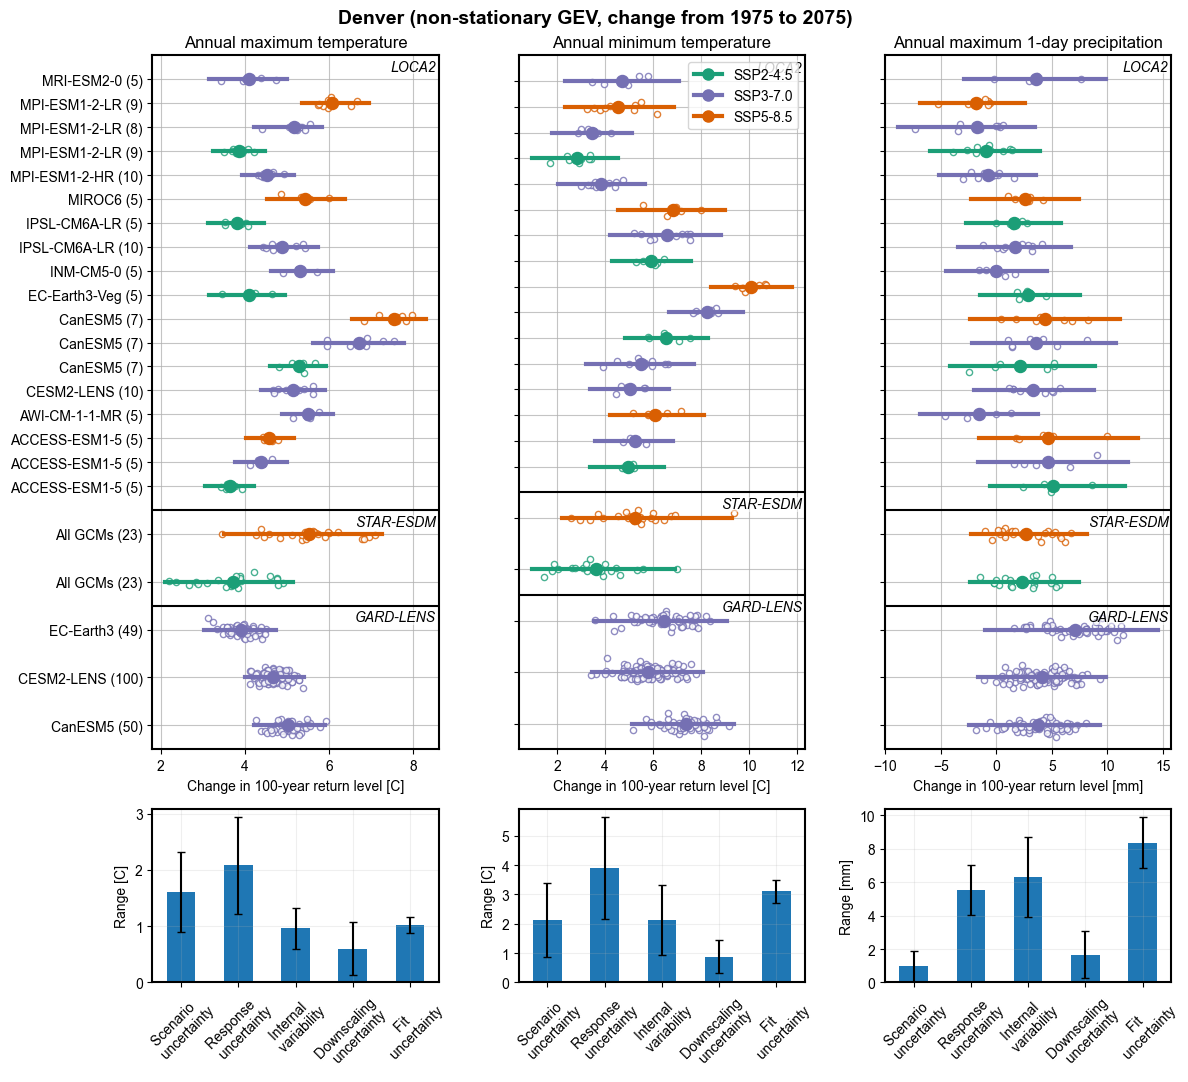

In [11]:
city = 'denver'
plot_col = '100yr_return_level_diff_2075-1975'
hist_slice = None
proj_slice = '1950-2100'
fit_method = 'mle'
stationary = False

metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

plot_city_metrics(city, metric_ids, plot_col, hist_slice, proj_slice, fit_method, stationary, title = '(non-stationary GEV, change from 1975 to 2075)', legend=1)

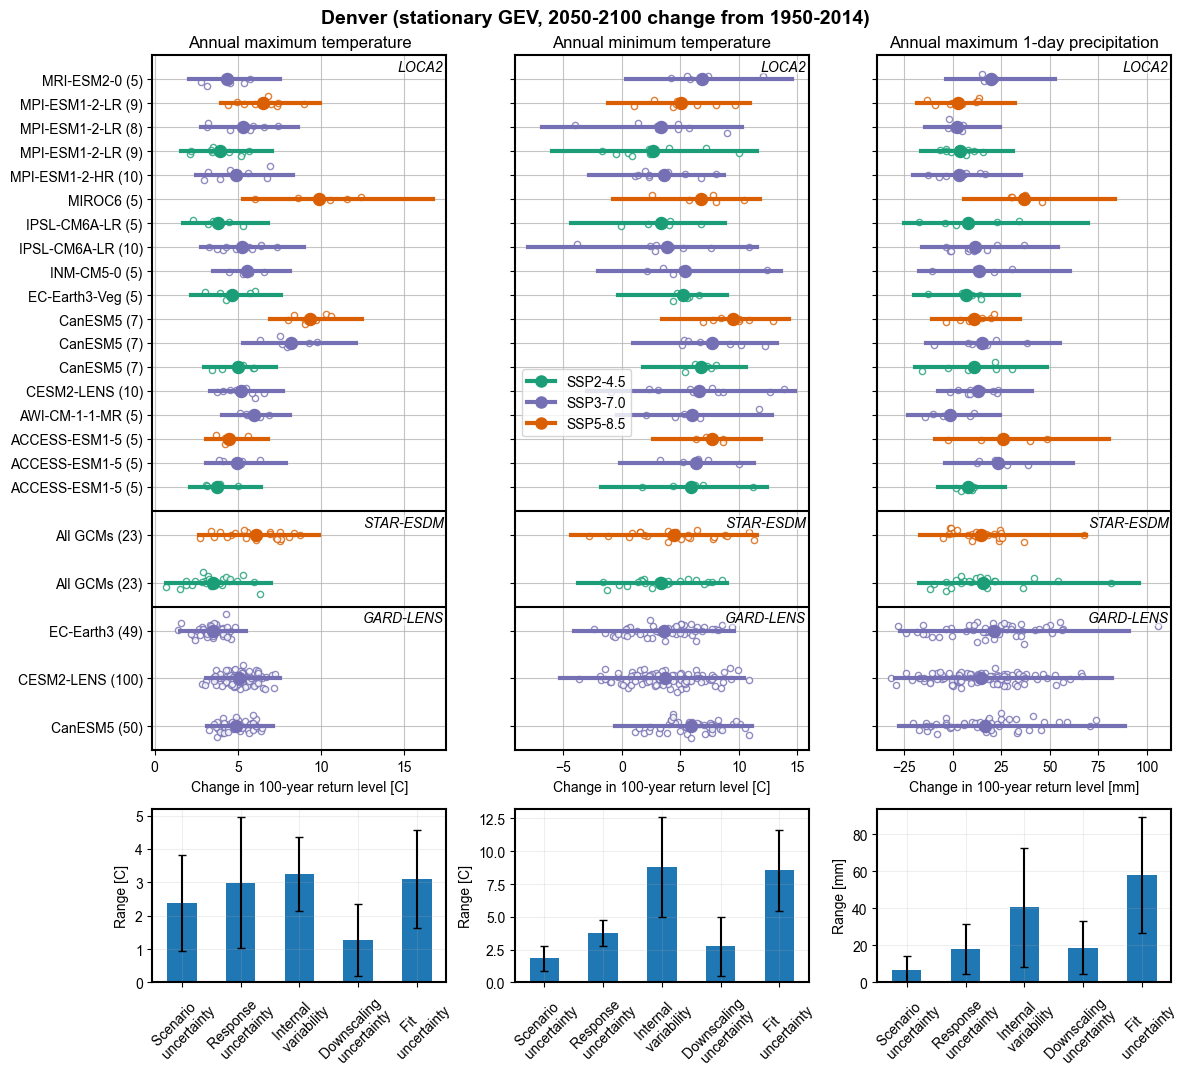

In [4]:
city = 'denver'
plot_col = '100yr_return_level_diff'
hist_slice = '1950-2014'
proj_slice = '2050-2100'
fit_method = 'lmom'
stationary = True

metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

plot_city_metrics(city, metric_ids, plot_col, hist_slice, proj_slice, fit_method, stationary, title = '(stationary GEV, 2050-2100 change from 1950-2014)', legend=1)